In [12]:
import cx_Oracle
import pandas as pd
connection = cx_Oracle.connect(user='scott', password='tiger', dsn='192.168.119.119:1521/dink11.dbsvr')
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tqdm


In [13]:
cursor = connection.cursor()
sql="select * from cardhistory where cardId='9440-9469-2724-7629'"
cursor.execute(sql)

rows = cursor.fetchall()
cursor.close()
columns = ['cardHisId','cardId', 'categoryBig', 'categorySmall','regionName', 'store', 'cardHisDate', 'cardHisTime', 'amount']
data = pd.DataFrame(rows, columns=columns)


In [14]:
# 인코딩한 값 가져오기
cursor = connection.cursor()
sql="select regionName, SEOULTTOREGIONDISTANCE from region"
cursor.execute(sql)

rows = cursor.fetchall()
columns = ['regionName','seoulTorReionDistance']
region = pd.DataFrame(rows, columns=columns)

cursor = connection.cursor()
sql="select categorySmall, barToEmbedding from category"
cursor.execute(sql)

rows = cursor.fetchall()
columns = ['categorySmall','barToEmbedding']
category = pd.DataFrame(rows, columns=columns)


In [15]:
data['categorySmall'] = data['categorySmall'].replace(category.set_index('categorySmall')['barToEmbedding'])
data['regionName'] = data['regionName'].replace(region.set_index('regionName')['seoulTorReionDistance'])
data['cardHisTime'] = data['cardHisTime'].str.split(':').str[0].astype(int)
data
# data = data.drop('categoryBig', axis=1)

,cardHisId,cardId,categoryBig,categorySmall,regionName,store,cardHisDate,cardHisTime,amount
0,2508200,9440-9469-2724-7629,요식/유흥,0.247283,40,양김남,2023-03-23,18,1800
1,2508201,9440-9469-2724-7629,미용,0.238686,1,박박김,2023-08-06,12,74000
2,2508202,9440-9469-2724-7629,음/식료품,0.230959,1,(주) 윤,2023-05-25,12,44000
3,2508203,9440-9469-2724-7629,스포츠/문화/레저,0.162976,1,(유) 이김김,2023-06-19,13,30800
4,2508204,9440-9469-2724-7629,의류/잡화,0.140980,1,김전,2023-05-08,14,98000
...,...,...,...,...,...,...,...,...,...
495,2508695,9440-9469-2724-7629,스포츠/문화/레저,0.066467,132,(유) 이김황,2023-07-26,20,20000
496,2508696,9440-9469-2724-7629,요식/유흥,0.099979,1,박김최,2023-03-04,17,25000
497,2508697,9440-9469-2724-7629,음/식료품,0.282791,1,(주) 황안최,2023-09-01,18,27000
498,2508698,9440-9469-2724-7629,유통,0.211717,40,유한회사 손,2023-07-14,14,45000


In [16]:
# data.to_csv("encodingData_7629.csv",encoding='utf-8')

### GMM

In [23]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

In [24]:
n_person = 1
n_components = 1
GMM_columns = ['categorySmall', 'regionName', 'cardHisTime', 'amount']
gmm = GaussianMixture(n_components=n_components)
X = data[GMM_columns].values 
X

array([[2.47283027e-01, 4.00000000e+01, 1.80000000e+01, 1.80000000e+03],
       [2.38685727e-01, 1.00000000e+00, 1.20000000e+01, 7.40000000e+04],
       [2.30958968e-01, 1.00000000e+00, 1.20000000e+01, 4.40000000e+04],
       ...,
       [2.82790810e-01, 1.00000000e+00, 1.80000000e+01, 2.70000000e+04],
       [2.11716667e-01, 4.00000000e+01, 1.40000000e+01, 4.50000000e+04],
       [2.84029752e-01, 1.00000000e+00, 2.10000000e+01, 9.20000000e+03]])

In [25]:
gmm.fit(X)

likelihoods = gmm.score_samples(X)
likelihoods_sort = np.sort(np.unique(likelihoods))
likelihoods_sort_idx = np.where(likelihoods==likelihoods_sort[0])

threshold =likelihoods_sort[0]
threhold_idx = likelihoods_sort_idx

means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

X_outlier = np.array([1, 400, 23.5, 1000000])
X_outlier_likeli = gmm.score_samples(X_outlier.reshape(1,-1))

In [26]:
categorySmall=str(means[0,0])+','+str(covariances[0,0,0])
regionName=str(means[0,1])+','+str(covariances[0,1,1])
cardHisTime=str(means[0,2])+','+str(covariances[0,2,2])
amount=str(means[0,3])+','+str(covariances[0,3,3])

In [ ]:
card_id = '9440-9469-2724-7629'

In [ ]:
# sql="update fds set categorySmall=:1, where cardid=:2";
# cursor.execute(sql,(categorySmall,card_id));

In [32]:
import pickle
# C:\Users\pooh5\Desktop\HANASelfFDS\python\analysis\gmm_9440-9469-2724-7629.pkl
# C:\Users\pooh5\Desktop\HANASelfFDS\python\analysis\gmm_model.pkl
card_id='9440-9469-2724-7629'
model_path = f'gmm_{card_id}.pkl'
with open(model_path, 'rb') as model_file:
        loaded_gmm = pickle.load(model_file)
means = loaded_gmm.means_
covariances = loaded_gmm.covariances_
weights = loaded_gmm.weights_

EOFError: Ran out of input

In [22]:
def is_outlier(data, model, threshold_likeli):

    data_likeli = model.score_samples(data.reshape(1,-1))
    return data_likeli < threshold_likeli

# Example
X_outlier_threshold = np.array([0.7, 300, 23 ,500000])
X_outlier_th_likeli = loaded_gmm.score_samples(X_outlier_threshold.reshape(1,-1))
data_to_check = np.array([0.6, 400, 20, 1000000])
is_anomaly = is_outlier(data_to_check, loaded_gmm, X_outlier_th_likeli)
print("Is the data an outlier?", is_anomaly)


NameError: name 'loaded_gmm' is not defined

In [60]:
model_file_path = 'gmm_model.pkl'
with open(model_file_path, 'rb') as model_file:
    loaded_gmm = pickle.load(model_file)
    
means = loaded_gmm.means_
covariances = loaded_gmm.covariances_
weights = loaded_gmm.weights_
print(means)

[[2.12382065e-01 6.06000000e+00 1.54720000e+01 5.21996000e+04]]


c:\Users\pooh5\anaconda3\envs\py37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [56]:
i=1
mean = means[0,i]
variance = covariances[0,i,i]

# PDF를 계산할 범위를 생성합니다.
pdf_x = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)

# 가우시안 분포의 PDF 계산
pdf = norm.pdf(pdf_x, loc=mean, scale=np.sqrt(variance))
pdf = norm.pdf(pdf_x, loc=mean, scale=np.sqrt(variance))
print(mean,variance,)
print(pdf_x.shape)
print(pdf.shape)

6.06 364.56840100000016
(1000,)
(1000,)


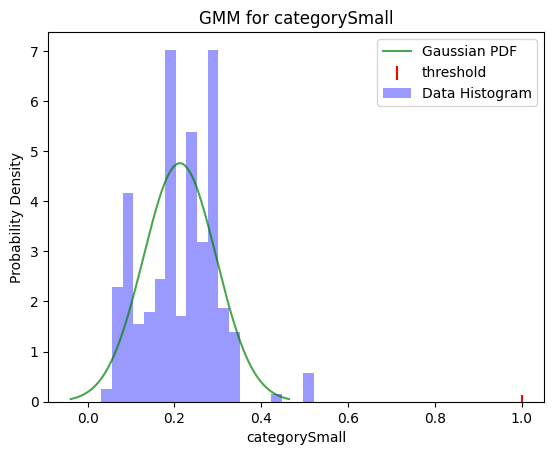

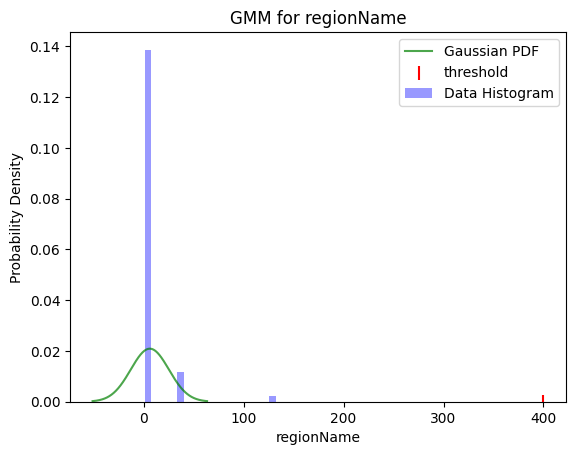

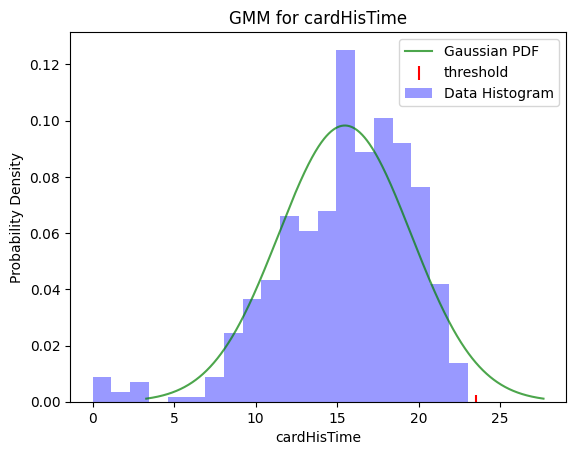

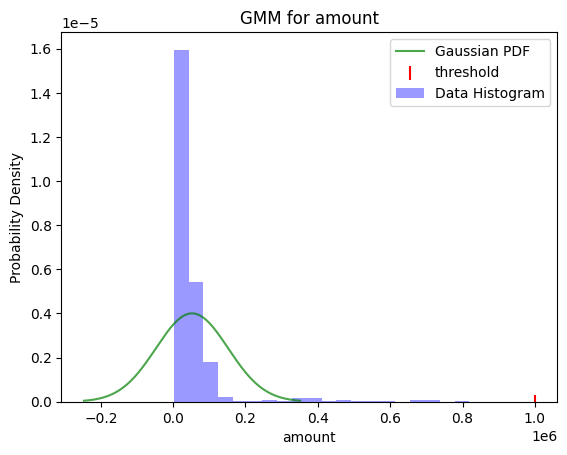

In [30]:
# GMM feature 별로 모수 분포 plot
from scipy.stats import norm


# Assuming df is your DataFrame and features is a list of feature column names
for i, feature in enumerate(GMM_columns):
    X_feature = X[:,i]

    mean = means[0,i]
    variance = covariances[0,i,i]
    
    # PDF를 계산할 범위를 생성합니다.
    pdf_x = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)

    # 가우시안 분포의 PDF 계산
    pdf = norm.pdf(pdf_x, loc=mean, scale=np.sqrt(variance))
    # print("mean",mean)
    # print("variance",variance)
    # print("pdf_x",pdf_x)
    
    # PDF 그래프 그리기
    
    plt.figure()
    plt.plot(pdf_x, pdf, color='green', alpha=0.7, label='Gaussian PDF')
    plt.scatter(X_outlier[i], 0, label='threshold', color='red', marker='|', s=100)  # 이상치를 빨간색으로 표시
    plt.hist(X_feature, bins=20, density=True, alpha=0.4, color='blue', label='Data Histogram')

    plt.title(f'GMM for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()
        

In [2]:
import pickle
# 모델을 저장할 파일 경로를 지정합니다.
model_file_path = 'gmm_9440-9469-2724-7629.pkl'

# 모델을 파일에 저장합니다.
with open(model_file_path, 'wb') as model_file:
    pickle.dump(gmm, model_file)

print(f"GMM 모델이 {model_file_path}에 저장되었습니다.")

NameError: name 'gmm' is not defined

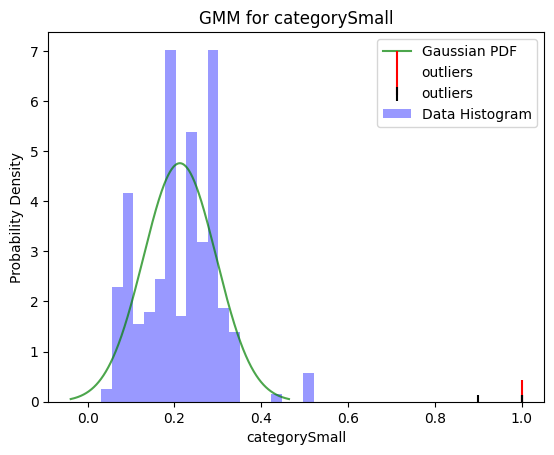

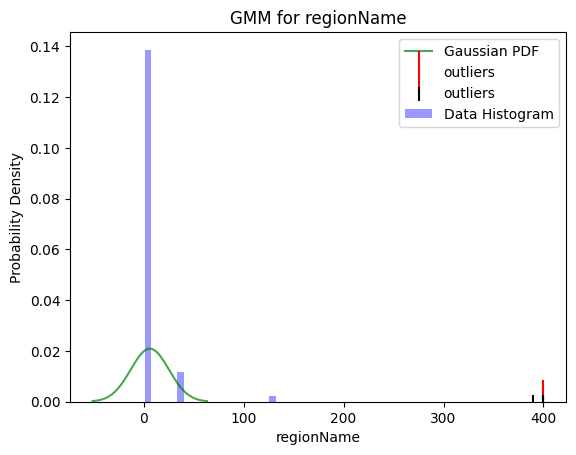

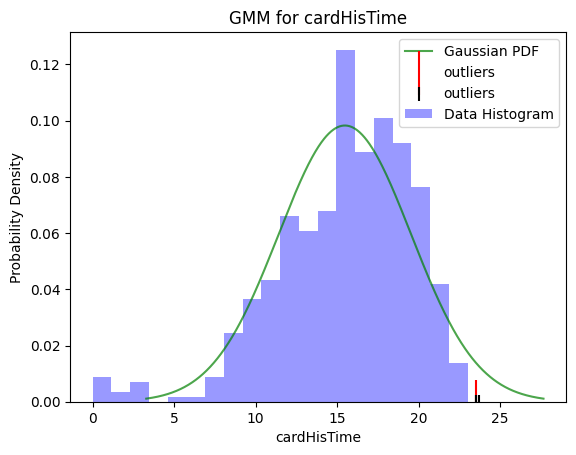

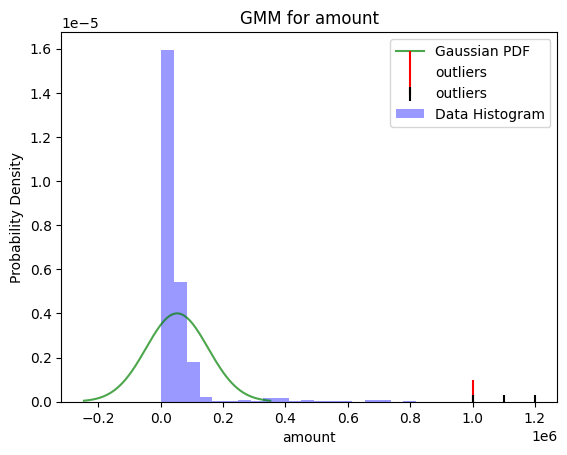

In [44]:



for i, feature in enumerate(GMM_columns):
    X_feature = X[:,i]

    mean = means[0,i]
    variance = covariances[0,i,i]
    
    # PDF를 계산할 범위를 생성합니다.
    pdf_x = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)

    # 가우시안 분포의 PDF 계산
    pdf = norm.pdf(pdf_x, loc=mean, scale=np.sqrt(variance))
    
    # PDF 그래프 그리기
    
    plt.figure()
    plt.plot(pdf_x, pdf, color='green', alpha=0.7, label='Gaussian PDF')
    plt.scatter(X_outlier_threshold[i], np.zeros_like(X_outlier_threshold[i]), label='outliers', color='red', marker='|', s=1000) 
    plt.scatter(X_outliers[:,i], np.zeros_like(X_outliers[:,i]), label='outliers', color='black', marker='|', s=100)  # 이상치를 빨간색으로 표시
    plt.hist(X_feature, bins=20, density=True, alpha=0.4, color='blue', label='Data Histogram')

    plt.title(f'GMM for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

In [15]:
import cx_Oracle
import pandas as pd
import os
import numpy as np
from sklearn.mixture import GaussianMixture
import pickle


connection = cx_Oracle.connect(user='scott', password='tiger', dsn='192.168.119.119:1521/dink11.dbsvr')

cursor = connection.cursor()
sql="select * from cardhistory where cardId='9751-1546-4512-7629'"

cursor.execute(sql)
rows = cursor.fetchall()

columns = ['cardHisId','cardId', 'categoryBig', 'categorySmall','regionName', 'store', 'cardHisDate', 'cardHisTime', 'amount']
data = pd.DataFrame(rows, columns=columns)

data['regionName'] = data['regionName'].apply(lambda x: x.split()[0])

sql="select regionName, SEOULTTOREGIONDISTANCE from REGIONembedding"
cursor.execute(sql)
rows = cursor.fetchall()
columns = ['regionName','seoulTorReionDistance']
region = pd.DataFrame(rows, columns=columns)


sql="select categorySmall, barToEmbedding from CATEGORYembedding"
cursor.execute(sql)
rows = cursor.fetchall()
columns = ['categorySmall','barToEmbedding']
category = pd.DataFrame(rows, columns=columns)

data['categorySmall'] = data['categorySmall'].replace(category.set_index('categorySmall')['barToEmbedding'])
data['regionName'] = data['regionName'].replace(region.set_index('regionName')['seoulTorReionDistance'])
data['cardHisTime'] = data['cardHisTime'].str.split(':').str[0].astype(int)

data.to_csv("newData.csv")

n_components = 1
GMM_columns = ['categorySmall', 'regionName', 'cardHisTime', 'amount']
loaded_gmm = GaussianMixture(n_components=n_components)
X = data[GMM_columns].values 
loaded_gmm.fit(X)

means = loaded_gmm.means_
covariances = loaded_gmm.covariances_

likelihoods = loaded_gmm.score_samples(X)
print("likelihoods",likelihoods)

#threshold로 할 이상치 데이터의 feature 값
X_outlier_threshold = np.array([0.8, 250, 20, 500000])
X_outlier_th_likeli = loaded_gmm.score_samples(X_outlier_threshold.reshape(1,-1))

print("X_outlier_th_likeli",X_outlier_th_likeli)

#outlier 데이터 인덱스
outlier_idx = np.where(likelihoods < X_outlier_th_likeli)
print("outlier_idx",outlier_idx)
#이상치 데이터 (임의로 정한 것 plot 위해서)
# X_outliers = np.array([[1, 400, 23.5, 1000000],[1, 400, 23.7, 1100000], [0.9, 390, 23.5, 1200000]])




likelihoods [ -7.79494556  -7.3481535   -8.49569868  -7.799395    -8.07935005
  -7.13139583  -8.2415182   -7.799395    -7.64374873  -7.4913278
  -7.29259617  -7.81615831  -8.00214465  -8.79897148  -8.09727072
  -8.27596862  -8.06436154  -8.22957648  -7.29812865  -7.22110118
  -8.23027265  -7.29049416  -7.74300262  -7.4867088   -8.08772999
  -8.82875678  -7.33926141  -7.24120552  -9.08599186  -7.7085997
  -8.24421496  -8.05547773  -8.07224016  -7.36155408  -7.29113994
  -8.12436868  -8.26781568  -8.19891771  -7.29197488  -7.22786782
  -7.11990687  -7.74341568  -8.71796227  -7.28127709  -7.79004707
  -8.16028235  -7.71119176  -8.09955341  -7.55217012  -9.01129399
  -7.50038106  -8.52450796  -8.10233203  -8.23345645  -7.71434768
  -8.1464121   -8.53458395  -8.1519846   -8.2884202   -7.75390783
  -8.11103098  -8.02426871  -8.54568044  -8.61561175  -9.34312324
 -56.09458319  -8.27774251  -7.82657485  -7.27100223  -7.09266271
  -7.59999207  -8.47730246  -8.45946983  -7.13658692  -7.98888595


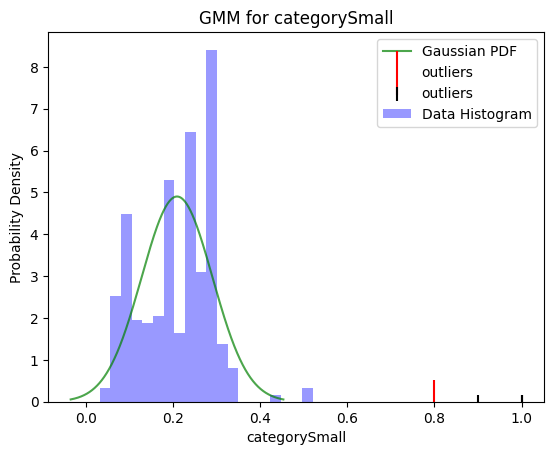

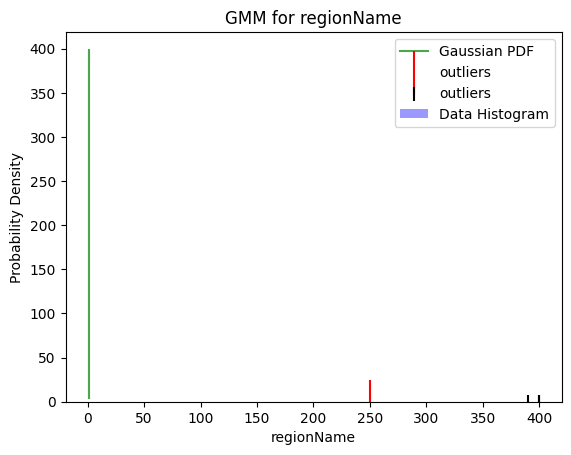

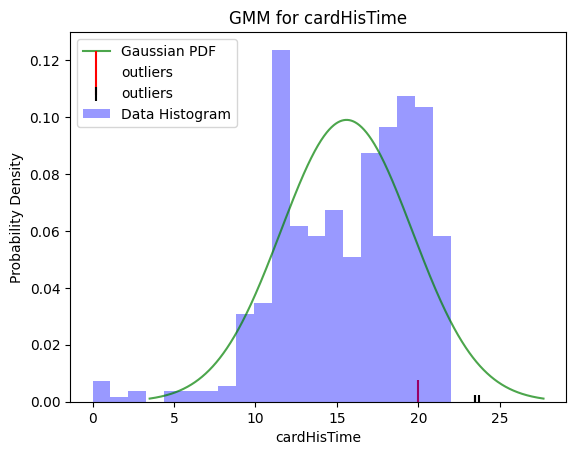

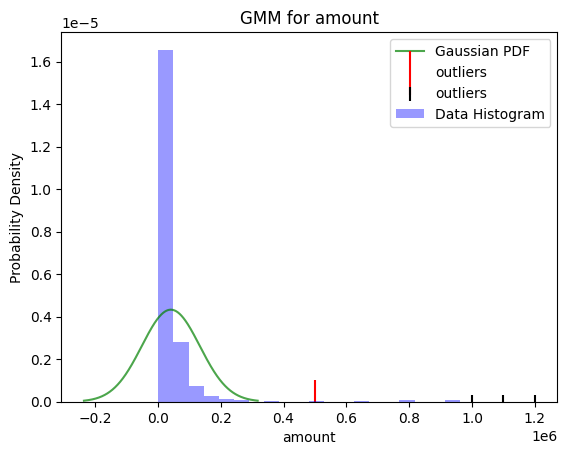

In [14]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm

for i, feature in enumerate(GMM_columns):
    X_feature = X[:,i]

    mean = means[0,i]
    variance = covariances[0,i,i]
    
    # PDF를 계산할 범위를 생성합니다.
    pdf_x = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)

    # 가우시안 분포의 PDF 계산
    pdf = norm.pdf(pdf_x, loc=mean, scale=np.sqrt(variance))
    
    # PDF 그래프 그리기
    
    plt.figure()
    plt.plot(pdf_x, pdf, color='green', alpha=0.7, label='Gaussian PDF')
    plt.scatter(X_outlier_threshold[i], np.zeros_like(X_outlier_threshold[i]), label='outliers', color='red', marker='|', s=1000) 
    plt.scatter(X_outliers[:,i], np.zeros_like(X_outliers[:,i]), label='outliers', color='black', marker='|', s=100)  # 이상치를 빨간색으로 표시
    plt.hist(X_feature, bins=20, density=True, alpha=0.4, color='blue', label='Data Histogram')

    plt.title(f'GMM for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()